# Programming for Data Science and Artificial Intelligence

## Unsupervised Learning - Clustering - GMM


## Name: Thantham Khamyai

## Student ID: 122097

### Task:
- Modify so it performs **early stopping when the log likelihood does not improve anymore**.  Note that if you log the normal distribution, you will get negative sign.  Thus if you ignore the negative sign, it will become negative likelihood, and thus will get smaller and smaller.
- Perform plotting every **5 iterations** on the resulting clusters.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

To make the model being the same way of the use, I keep the step to use model as Model() -> fit -> predict.

This will be satisfied for further use of the model.

Also, make it to be a class is easier to use and modify

In [2]:
from scipy.stats import multivariate_normal
import math
import time

class GMM:
    
    def __init__(self,k=3, max_iter=20, early_stopping=False, tol=5, verbose=False, plot_every=None, random_state=None):
        
        self.K = k # define k 
        self.max_iter = max_iter
        self.early_stopping = early_stopping
        self.tol = tol # early stopping threshold
        self.verbose = verbose # how NLL while training
        self.plot_every = False if plot_every == None else plot_every # if not define iterative plot
        self.prev_nll = 0 # NLL comparator
        
        if random_state: np.random.seed(random_state) # define if random state was init
    
    def fit(self, X):
        
        time_start = time.time() # init time start
        
        m,n  = X.shape # get m n
        
        # init responsibility (Likelihood coresponding for each class)
        self.r = np.full(shape=(m, self.K), fill_value=1/self.K)
        
        # init pi (identity pi for each k)
        self.pi = np.full((self.K, ), fill_value=1/self.K)
        
        # init mean (random mean LL of classes by random from samples)
        init_points = np.random.randint(low=0, high=m, size=self.K)
        self.mean = np.array([X[idx,:] for idx in init_points ]).T
        
        # init covariance (covariance for each class)
        self.cov = np.array([np.cov(X.T) for _ in range (self.K)])
        
        # looping
        iter = 0
        while iter < self.max_iter:
            
            # ================================= E step================================================
            
            # ----------------------  Find Likelihood ------------------------
            for i in range(m): # for every samples
                for k in range(self.K): # in each class of sample i
                    xi_pdf = multivariate_normal.pdf(X[i], mean=self.mean[:, k], cov=self.cov[k]) # calc gaussian prob. of xi in class i 
                    self.r[i, k] = self.pi[k] * xi_pdf # multiply gs. prob. by pi of class i -> save at r at sample i, class k
                self.r[i] /= np.sum(self.r[i]) # normalize likelihood

            # ------------------------ find neg likelihood --------------------- (metric of GMM)(similar to cost value)
            NLL = 0 # init NLL at 0.0
            for i in range(m): # for each sample
                for k in range(self.K): # in each class k
                    NLL += math.log(self.pi[k]) # log of pi of class k at sample i
                    NLL += multivariate_normal.logpdf(X[i], mean=self.mean[:, k], cov=self.cov[k]) # accumulate gs prob 

            # ------------- every 5 iteration plot once---------------------
            
            if self.plot_every and iter % self.plot_every ==0:
                preds = np.argmax(self.r, axis=1)
                plt.figure()
                plt.scatter(X[:, 0], X[:, 1], c=preds)
                plt.title(f"Iteration: {iter}")
                plt.show()
                
            if self.verbose: # if verbose set True -> show cost at iter i+1
                print(f'iter {iter+1}, different NLL: {math.fabs(NLL - self.prev_nll)}')

            # ------------------------------ Check if early stop -----------------------
            # if early stopping was set and abs(difference of NLL) < tolerance -> stop
            if(self.early_stopping and math.fabs(NLL-self.prev_nll) < self.tol): # fabs following Task 1
                
                if self.verbose:
                    print('Early Stopped with tol: ', self.tol)
                #print("Final NLL: ", NLL)
                    print("final difference: ", math.fabs(NLL - self.prev_nll)) # ignoring negative sign
                break
            
            # if not continue iteration with set current NLL
            self.prev_nll = NLL

            #=========================================M Step==============================================
            
            # Find NK first for later use
            self.NK = np.sum(self.r, axis=0)
            assert self.NK.shape == (self.K, )

            #PI
            self.pi = self.NK / m
            assert self.pi.shape == (self.K, )

            #mean
            self.mean =  ( X.T @ self.r ) / self.NK
            assert self.mean.shape == (n, self.K)

            # ------------------------------------- update sigma ---------------------------------------------
            
            # update sigma of gm
            for k in range(self.K): # for each class k
                for i in range(m): # in each sample i
                    X_mean = (X[i]-self.mean[:, k]).reshape(-1, 1) # calc means
                    self.cov[k] += self.r[i, k] * (X_mean @ X_mean.T) # calc covatiance
                self.cov[k] /= self.NK[k] # after each k -> cumulative divide by NK
            assert self.cov.shape == (self.K, n, n)
            
            iter += 1 # go next iteration
        
        self.fit_time = time.time() - time_start # when fitting ended -> save fitting time
        
        if self.verbose: print(f'fitting time: {self.fit_time} seconds') # show fitting time

    def predict(self, X):
        
        m,n = X.shape # get m n of xtest
        
        preds = np.zeros(shape=(m, self.K)) # init result coresponding each k
        
        for i in range(m): # for each x test i
            for k in range(self.K): # in each class k
                
                xi_pdf = multivariate_normal.pdf(X[i], mean=self.mean[:, k], cov=self.cov[k]) # calc gs prob
                preds[i, k] = self.pi[k] * xi_pdf # miltoply it by pi of class k
                
            preds[i] /= np.sum(preds[i]) # normalize likelihood
            
        return np.argmax(preds, axis=1) # return argmax
    
    def predict_proba(self, X):
        
        m,n = X.shape # get m n of xtest
        
        preds = np.zeros(shape=(m, self.K)) # init result coresponding each k
        
        for i in range(m): # for each x test i
            for k in range(self.K): # in each class k
                
                xi_pdf = multivariate_normal.pdf(X[i], mean=self.mean[:, k], cov=self.cov[k]) # calc gs prob
                preds[i, k] = self.pi[k] * xi_pdf # miltoply it by pi of class k
                
            preds[i] /= np.sum(preds[i]) # normalize likelihood
            
        return preds # return raw before argmax

The data for model testing will be more challange to convince reader that the model works well

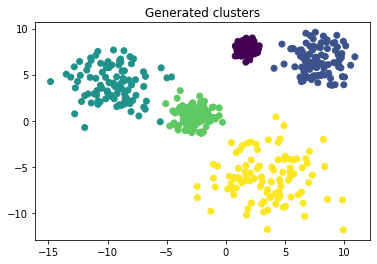

In [3]:
from sklearn.datasets import make_blobs

X, y = make_blobs(centers=5, n_samples=500, cluster_std=[0.5, 1.5, 2.0, 1.0, 2.5], random_state=20)

plt.scatter(X[:,0], X[:,1], c=y)
plt.title('Generated clusters')
plt.show()

The data will be 4 clusters with some different of cluster dispersion pattern. the size of samples I reduce to 400 for better timimg

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

This step actually not neccessary, but I just split for plot thre result only test set 

### Model Testing (Combine 2 Tasks together)

**I combined an early_stopping option and activated plot_every option as interger (if None, it is deactivated)**

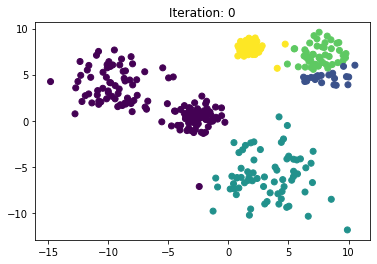

iter 1, different NLL: 15097.491525281517
iter 2, different NLL: 266.6417776849303
iter 3, different NLL: 2313.252030976817
iter 4, different NLL: 4424.486192213513
iter 5, different NLL: 8762.692559551604


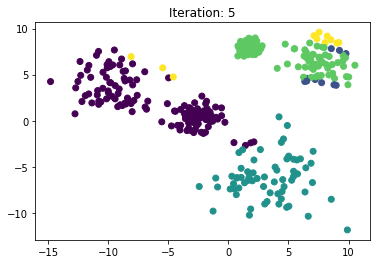

iter 6, different NLL: 8206.620163686468
iter 7, different NLL: 4419.0388005817
iter 8, different NLL: 3646.5883293464867
iter 9, different NLL: 5074.973198451211
iter 10, different NLL: 7346.3543490206575


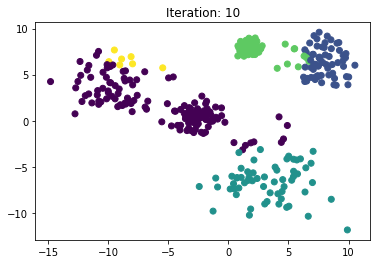

iter 11, different NLL: 10195.280164178177
iter 12, different NLL: 7859.998251826983
iter 13, different NLL: 3041.3670453717496
iter 14, different NLL: 2869.1339630894363
iter 15, different NLL: 12470.863998578658


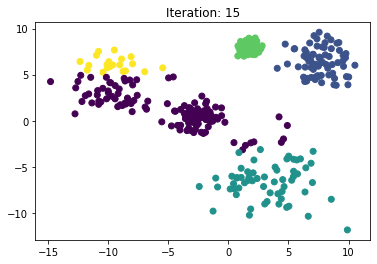

iter 16, different NLL: 15807.0201529162
iter 17, different NLL: 1300.2182324343885
iter 18, different NLL: 443.53497550281463
iter 19, different NLL: 452.2950839111145
iter 20, different NLL: 325.01355738489656


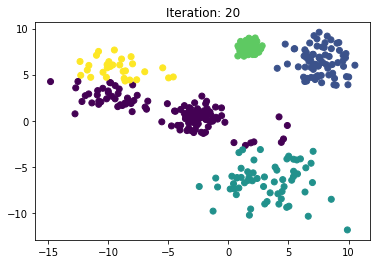

iter 21, different NLL: 272.49461862497265
iter 22, different NLL: 231.7181662250223
iter 23, different NLL: 197.84055228591023
iter 24, different NLL: 172.72464945307001
iter 25, different NLL: 154.51847485096368


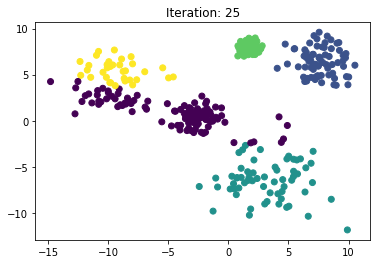

iter 26, different NLL: 140.85038337198785
iter 27, different NLL: 130.18822444905527
iter 28, different NLL: 121.75659429661755
iter 29, different NLL: 115.18994164084143
iter 30, different NLL: 110.29586554710113


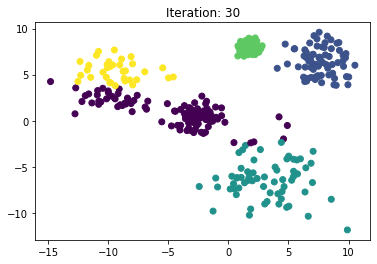

iter 31, different NLL: 106.94524278407334
iter 32, different NLL: 105.03280941089906
iter 33, different NLL: 104.46406678945641
iter 34, different NLL: 105.14416499962681
iter 35, different NLL: 106.95362483862846


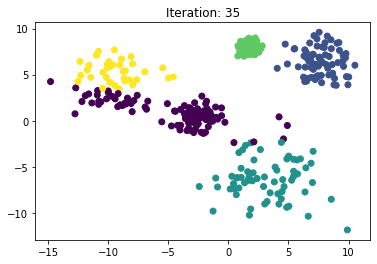

iter 36, different NLL: 109.69273678604804
iter 37, different NLL: 112.95841012829624
iter 38, different NLL: 115.87411530404643
iter 39, different NLL: 116.51728088130767
iter 40, different NLL: 110.88530353840906


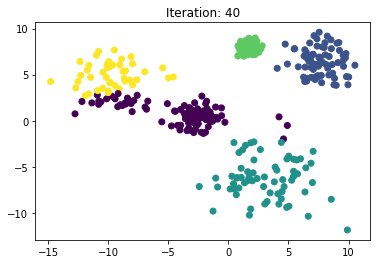

iter 41, different NLL: 92.1659790880658
iter 42, different NLL: 55.70713635723223
iter 43, different NLL: 17.270621985167963
iter 44, different NLL: 9.66761928141932
iter 45, different NLL: 29.495456717602792


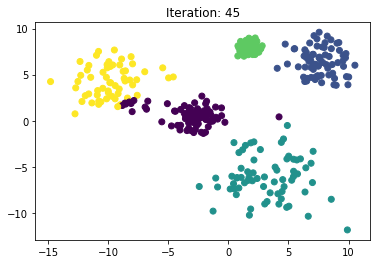

iter 46, different NLL: 50.36212018491642
iter 47, different NLL: 44.651087310150615
iter 48, different NLL: 79.06448446615832
iter 49, different NLL: 540.0950763939618
iter 50, different NLL: 1299.9320236612693


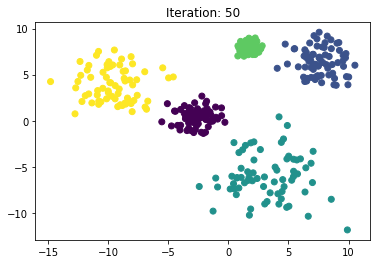

iter 51, different NLL: 1320.855758820704
iter 52, different NLL: 253.88367580134945
iter 53, different NLL: 34.30789108375029
iter 54, different NLL: 10.488957243811456
iter 55, different NLL: 4.035376592029934


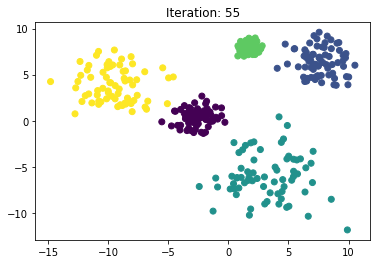

iter 56, different NLL: 1.6151710657286458
Early Stopped with tol:  3
final difference:  1.6151710657286458
fitting time: 30.69932246208191 seconds


In [8]:
model = GMM(k=5, verbose=True, max_iter = 100, early_stopping=True, tol=3, plot_every=5)
model.fit(X_train)

After fitting, the imtermidiate result looks good. However, we will use test set to plot the result

In [9]:
y_pred = model.predict(X_test)

Plot the predicted class of each cluster on test set

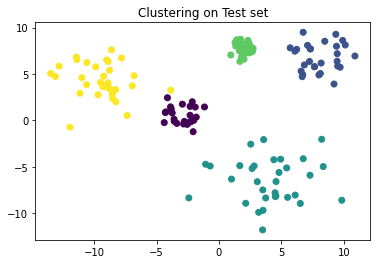

In [10]:
plt.scatter(X_test[:,0], X_test[:, 1], c=y_pred)
plt.title('Clustering on Test set')
plt.show()

## Conclusion

GMM is another clustering algorithm as solution that Kmeans' problem. If the data distrubution looks unequal circular shape and different dispersed strength (std), this model might be the best option to do clustering

However, the consideration of this model is the random initation of means of clusters. If it was initialized not well, it might take more iterations to converge or hard convergence. So that, using GMM should be considered about the uncertainty of random initation of clusters' mean.